# Training a Deep Learning Model for Handwriting Recognition using VGG16 (CNN)

## Overview
This Jupyter notebook demonstrates how to train a Convolutional Neural Network (CNN) for recognizing handwritten words using the **VGG16** architecture. The objective is to apply deep learning techniques, particularly using **Computer Vision (CV)** methods, to accurately recognize and classify words written by hand.

### The scheme to implement a model with keras:

* Architecture of the model
* Compiling the model
* Training of the model Diagnosis of the training
* Evaluation of predictions


## Importing Required Libraries

In this section, we import all the necessary libraries and modules. These libraries are used for tasks like data manipulation, image processing, deep learning model creation, and evaluation. The imports are organized based on their functionality.


In [1]:
# Data Manipulation and Utilities
import pandas as pd
import numpy as np
from tqdm import tqdm  # For displaying progress bars
import os

# Image Processing
import cv2
from PIL import Image

# TensorFlow and Keras - Deep Learning Libraries
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model


# Machine Learning Utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

# Plotting and Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import itertools


# NLP Utility to Import Stopwords Listimport nltk
import nltk
from nltk.corpus import stopwords



# Inline Plotting for Jupyter Notebook
%matplotlib inline

## Loading and Preprocessing Dataset

In this section, we load the handwritten text dataset from a specified directory and create a structured dataset that combines image paths with their corresponding transcription labels. We also verify the availability of image files to filter out corrupted or missing entries.

- **Dataset Path**: We define the root path to the image dataset.
- **Word Transcriptions**: We read the `words.txt` file, which contains metadata about the handwritten samples, including file names and corresponding transcriptions.
- **Data Integrity Check**: We ensure that all referenced images exist and are not corrupted. Invalid entries are counted.


In [2]:
# Define the dataset path
dataset_path = '../../words'  # Update this path based on your specific directory structure

# Initialize data list and load transcription file
data = []  # List to store dataset information
words = open("../ascii/words.txt", "r").readlines()  # Read the words.txt file which contains metadata for each image
inexistent_or_corrupted = 0  # Counter for inexistent or corrupted image files

# Iterate over each line of the metadata file
for line in tqdm(words):
    if line.startswith("#"):  # Skip header lines that start with '#'
        continue

    # Split the line into different components
    parts = line.strip().split()
    fixed_part = parts[:8]  # Extract fixed part of the metadata (e.g., ID, coordinates, etc.)
    transcription_part = ' '.join(parts[8:])  # Extract the transcription part (actual word)

    # Construct folder paths and image file names
    line_split = line.split(" ")
    folder_parts = line_split[0].split('-')
    folder1 = folder_parts[0]
    folder2 = folder_parts[0] + '-' + folder_parts[1]
    file_name = line_split[0] + ".png"
    label = line_split[-1].rstrip('\n')

    # Construct the relative path for the image
    rel_path = os.path.join(dataset_path, folder1, folder2, file_name)

    # Check if the image exists and is not corrupted (file size > 0)
    if os.path.exists(rel_path) and os.path.getsize(rel_path) > 0:
        # Append metadata and image path to data list
        data.append(fixed_part + [transcription_part, rel_path])
    else:
        # Increment counter if image is missing or corrupted
        inexistent_or_corrupted += 1

# Print the count of inexistent or corrupted images
print('Number of inexistent or corrupted files:', inexistent_or_corrupted)

# Create a DataFrame from the collected data
df = pd.DataFrame(data, columns=['line_id', 'result', 'graylevel', 'x', 'y', 'w', 'h', 'annotation', 'transcription', 'image_path'])
display(df.head())  # Display the first few rows of the DataFrame


100%|██████████| 115338/115338 [00:13<00:00, 8631.81it/s] 


Number of inexistent or corrupted files: 2


,line_id,result,graylevel,x,y,w,h,annotation,transcription,image_path
0,a01-000u-00-00,ok,154,408,768,27,51,AT,A,../../words\a01\a01-000u\a01-000u-00-00.png
1,a01-000u-00-01,ok,154,507,766,213,48,NN,MOVE,../../words\a01\a01-000u\a01-000u-00-01.png
2,a01-000u-00-02,ok,154,796,764,70,50,TO,to,../../words\a01\a01-000u\a01-000u-00-02.png
3,a01-000u-00-03,ok,154,919,757,166,78,VB,stop,../../words\a01\a01-000u\a01-000u-00-03.png
4,a01-000u-00-04,ok,154,1185,754,126,61,NPT,Mr.,../../words\a01\a01-000u\a01-000u-00-04.png


## Interactive Visualization of Transcription Frequency Distribution

Before applying any filtering, it is helpful to visualize the distribution of transcription frequencies. This plot provides insights into the number of times each transcription appears in the dataset, helping us understand which classes might be overrepresented or underrepresented.

This plot includes several interactive features:
- **Hover Tooltips**: Hover over the data points to see detailed information.
- **Zoom Options**: Use mouse controls to zoom in and out of specific areas of the plot.
- **Toggle Axis Type**: The plot has buttons to toggle between linear and log scales for both axes, making it easier to explore the distribution.

In [3]:
# Prepare the data for Plotly
transcription_counts = df['transcription'].value_counts()
frequency_counts = transcription_counts.value_counts().sort_index()

# Create a figure using Plotly
fig = go.Figure()

# Add scatter trace for the data points
fig.add_trace(go.Scatter(
    x=frequency_counts.index, 
    y=frequency_counts.values, 
    mode='markers+lines',
    marker=dict(size=6, color='red'),
    name='Frequency of Transcriptions',
    hoverinfo='x+y'
))

# Update axis labels and title
fig.update_layout(
    title='Frequency of Repetitions of Transcriptions',
    xaxis=dict(
        title='Number of Occurrences of Transcription',
        type='log',  # Initially set to log scale
    ),
    yaxis=dict(
        title='Frequency (Count of Transcriptions)',
        type='log',  # Initially set to log scale
    ),
    xaxis_title='Number of Occurrences of Transcription',
    yaxis_title='Frequency (Count of Transcriptions)',
    hovermode='closest'
)

# Add buttons to switch between log and linear scales
fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="left",
            buttons=list([
                dict(
                    args=[{"xaxis.type": "log", "yaxis.type": "log"}],
                    label="Log-Log Scale",
                    method="relayout"
                ),
                dict(
                    args=[{"xaxis.type": "linear", "yaxis.type": "linear"}],
                    label="Linear Scale",
                    method="relayout"
                ),
                dict(
                    args=[{"xaxis.type": "log", "yaxis.type": "linear"}],
                    label="Log X - Linear Y",
                    method="relayout"
                ),
                dict(
                    args=[{"xaxis.type": "linear", "yaxis.type": "log"}],
                    label="Linear X - Log Y",
                    method="relayout"
                )
            ]),
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.11,
            xanchor="left",
            y=1.15,
            yanchor="top"
        ),
    ]
)

# Show the plot
fig.show()


## Filtering Transcriptions by Frequency

To improve the quality and balance of the dataset, we filter the transcriptions based on their frequency. Transcriptions that occur either too frequently or too rarely can lead to imbalance or overfitting during model training. In this section, we:

1. Set a range for transcription frequency.
2. Filter the dataset to keep only transcriptions that fall within the desired range.
3. Reset the index to ensure the filtered DataFrame has a clean, continuous index.
4. Print the unique transcriptions in the filtered dataset to verify the diversity.

In [4]:
# Set the minimum and maximum sample counts for filtering transcriptions
min_samples = 100  # Minimum number of occurrences for a transcription to be included
max_samples = 200  # Maximum number of occurrences for a transcription to be included

# Filter transcriptions based on the specified count thresholds
class_counts = df['transcription'].value_counts()  # Get the count of each transcription
classes_to_keep = class_counts[(class_counts >= min_samples) & (class_counts <= max_samples)].index  # Identify transcriptions to retain
df_filtered = df[df['transcription'].isin(classes_to_keep)].copy()  # Create a filtered DataFrame containing only the selected transcriptions

# Reset index after filtering to ensure a clean, continuous index
df_filtered.reset_index(drop=True, inplace=True)

# Print unique transcriptions remaining in the filtered dataset
print(df_filtered['transcription'].unique())  # Helps to verify the diversity of retained transcriptions


['A' 'any' 'made' 'may' 'some' 'into' 'now' 'up' 'two' ')' ':' 'We' 'what'
 'do' 'if' 'them' 'But' 'told' 'no' 'about' 'these' 'can' 'over' 'And'
 'than' 'new' 'This' 'other' 'first' 'people' 'my' 'when' 'In' 'much'
 'could' 'being' 'time' 'man' 'very' 'its' 'like' 'only' 'well' 'You'
 '...' "'s" 'me']


## Removing Stopwords and Specific Unwanted Transcriptions

To further clean the dataset, we remove common stopwords and specific unwanted symbols or suffixes. Stopwords are words that carry little meaning, such as 'and', 'the', or 'of', which can add noise to the model training process. Additionally, certain symbols or suffixes are removed to make the data more consistent and useful for training.

### Steps:
1. **Download Stopwords**:  
   Use NLTK to download the standard list of English stopwords, which are words that are generally not useful for model training.
2. **Remove Specific Unwanted Transcriptions**:  
   Update the set of stopwords with specific unwanted symbols, such as `')'`, `':'`, `'...'`, and `"'s"`, to further clean the dataset.
3. **Filter Out Unwanted Transcriptions**:  
   Remove all transcriptions from the dataset that match any of the stopwords or unwanted symbols. This step helps ensure that only meaningful transcriptions are retained.

In [5]:
# Download stopwords list from NLTK
nltk.download('stopwords')

# Create a set of English stopwords
stop_words = set(stopwords.words('english'))

# Remove specific unwanted transcriptions by adding symbols to the stopwords set
stop_words.update([')', ':', '...', "'s"])  # Adding symbols and suffixes to the stopwords set for further cleaning

# Filter out transcriptions that are in the stopwords list
df_filtered = df_filtered[~df_filtered['transcription'].isin(stop_words)]  # Remove transcriptions that match stopwords

# Print the number of unique transcriptions remaining in the filtered dataset
print('Number of remained unique values: ', df_filtered['transcription'].nunique())  # Display the count of unique values to verify filtering

# Print the unique transcriptions remaining in the dataset
print('Remained unique values: ', df_filtered['transcription'].unique())  # Display the remaining unique transcriptions for verification

Number of remained unique values:  20
Remained unique values:  ['A' 'made' 'may' 'two' 'We' 'But' 'told' 'And' 'new' 'This' 'first'
 'people' 'In' 'much' 'could' 'time' 'man' 'like' 'well' 'You']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Besitzer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Interactive Visualization of Transcription Counts

In this section, we create a bar plot to visualize the distribution of transcriptions in the filtered dataset. Understanding the frequency of each transcription helps us identify any remaining imbalance in the dataset and assess the need for further processing.

- **Plotting Frequency Distribution**: We plot the count of each transcription using a bar chart to observe the frequency distribution. This allows us to visually confirm that the dataset is reasonably balanced.

In [6]:
# Create a DataFrame for plotting purposes
transcription_counts = df_filtered['transcription'].value_counts().reset_index()
transcription_counts.columns = ['Transcription', 'Count']

# Create an interactive bar plot using Plotly
fig = px.bar(
    transcription_counts, 
    x='Transcription', 
    y='Count', 
    title='Counts of Each Transcription',
    labels={'Transcription': 'Transcription', 'Count': 'Count'},
    hover_data=['Count'],  # Show the count on hover
    template='plotly_white'  # Use a clean style for better visuals
)

# Customize the layout for better visibility
fig.update_layout(
    xaxis_tickangle=-45,  # Rotate x-axis labels for better readability
    title_x=0.5,  # Center the title
    title_font_size=20,  # Increase the title font size
    xaxis_title_font_size=16,  # Increase x-axis label font size
    yaxis_title_font_size=16  # Increase y-axis label font size
)

# Show the interactive plot
fig.show()

* preparing image data

## Encoding Transcriptions

To use categorical data such as transcriptions in a machine learning model, we need to convert them into a numerical format. In this step, we use `LabelEncoder` to transform each unique transcription into a unique integer label. This encoded format makes the labels usable in the deep learning model.


In [7]:
# Encode the transcriptions
le = LabelEncoder()
df_filtered['transcription_encoded'] = le.fit_transform(df_filtered['transcription'])  # Encode transcriptions to numerical values

# Display the first few rows of the updated DataFrame to verify encoding
display(df_filtered.head())

# Create a mapping between transcriptions and their encoded labels
transcription_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Transcription Encoding Mapping:")
for transcription, code in transcription_mapping.items():
    print(f"'{transcription}' : {code}")




,line_id,result,graylevel,x,y,w,h,annotation,transcription,image_path,transcription_encoded
0,a01-000u-00-00,ok,154,408,768,27,51,AT,A,../../words\a01\a01-000u\a01-000u-00-00.png,0
2,a01-000u-02-03,ok,157,916,1136,281,46,VBN,made,../../words\a01\a01-000u\a01-000u-02-03.png,10
3,a01-000x-00-00,ok,182,375,767,35,67,AT,A,../../words\a01\a01-000x\a01-000x-00-00.png,0
5,a01-000x-01-08,ok,181,1649,931,125,77,VBN,made,../../words\a01\a01-000x\a01-000x-01-08.png,10
6,a01-003-00-02,ok,176,749,945,127,56,MD,may,../../words\a01\a01-003\a01-003-00-02.png,12


Transcription Encoding Mapping:
'A' : 0
'And' : 1
'But' : 2
'In' : 3
'This' : 4
'We' : 5
'You' : 6
'could' : 7
'first' : 8
'like' : 9
'made' : 10
'man' : 11
'may' : 12
'much' : 13
'new' : 14
'people' : 15
'time' : 16
'told' : 17
'two' : 18
'well' : 19


## Preprocessing Images

To prepare the images for model training, we need to process them into a consistent format that our model can use. In this step, we:
1. **Load Images**: Convert images to RGB format for uniformity.
2. **Resize Images**: Resize them to `(32, 32)` to match the input requirements for our model.
3. **Apply Preprocessing**: Use the `preprocess_input()` function from VGG16, which ensures the images are in the correct format for the VGG16 model.

We encapsulate this logic in a function for modularity and reusability.


In [10]:
# Function to preprocess images and extract features and labels
def preprocess_images(df, width=32, height=32):
    X, Y = [], []
    for index, row in df.iterrows():
        # Open and preprocess each image
        image = Image.open(row['image_path']).convert('RGB').resize((width, height))  # Convert to RGB and resize
        image = np.array(image)
        image = preprocess_input(image)  # VGG16 preprocessing
        X.append(image)
        Y.append(row['transcription_encoded'])
    return np.array(X), np.array(Y)

# Preprocess images and extract features (X) and labels (Y)
X, Y = preprocess_images(df_filtered)

## Normalizing and Verifying Data

After preprocessing, we normalize the pixel values of the images to be between `0` and `1`. This normalization step helps in faster convergence during model training. We also verify the range of values to ensure the normalization is done correctly. Lastly, we check that the number of features (`X`) matches the number of labels (`Y`), ensuring data consistency.


In [11]:
# Normalize the features and verify
X = X / 255.0  # Normalize images to scale pixel values between 0 and 1
print('Min: %.3f, Max: %.3f' % (X.min(), X.max()))  # Check normalization range

# Verify the length of X and Y
print('X and Y have the same length: ', len(X) == len(Y))  # Verify consistency

Min: -0.477, Max: 0.592
X and Y have the same length:  True


## Splitting the Data into Training and Testing Sets

After preprocessing and encoding, we need to split the dataset into training and testing sets to train our model and evaluate its performance. In this step, we use `train_test_split` from Scikit-learn:

- **Training Set**: Used to train the deep learning model.
- **Testing Set**: Used to evaluate how well the model generalizes to unseen data.

We also use stratification to ensure that the class distribution in the training and testing sets is similar, which helps maintain balance between different classes.


In [12]:

# Split the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, 
    test_size=0.2,  # 20% of the data will be used for testing
    random_state=42,  # Set random seed for reproducibility
    stratify=Y  # Ensure class distribution remains balanced between train and test sets
)

# X_train, X_test: Feature sets for training and testing
# Y_train, Y_test: Corresponding labels for training and testing


## Visualizing a Random Sample Image with its Transcription

In this step, we visualize a random sample image from the training set along with its corresponding original transcription. This random selection helps in verifying that our preprocessing, encoding, and data preparation steps are working correctly across different samples.

### Steps:
1. **Select a Random Image**: Randomly select an index from the training set.
2. **Find the Original Transcription**: Use the selected index to look up the corresponding transcription from the DataFrame.
3. **Display the Image**: Display the randomly selected image and its transcription.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Translation = In


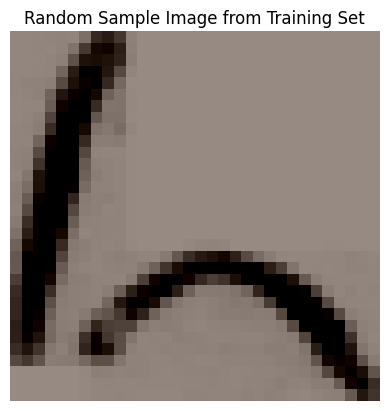

In [13]:
# Display a random sample from the training set
random_idx = np.random.randint(len(Y_train))  # Randomly select an index from the training set

# Find the corresponding original transcription using the encoded value
idx = np.where(df_filtered['transcription_encoded'].values == Y_train[random_idx])[0][0]  # Find the index in the DataFrame corresponding to the encoded label
print('Translation =', df_filtered['transcription'].iloc[idx])  # Print the original transcription

# Display the randomly selected sample image from the training set
plt.imshow(X_train[random_idx], cmap='gray')  # Display the image in grayscale
plt.title('Random Sample Image from Training Set')
plt.axis('off')  # Hide the axis for better visualization
plt.show()


## Calculating Class Weights Manually

To address potential class imbalances in the dataset, we manually calculate class weights. When the dataset has some classes that are much more frequent than others, training the model without compensation may result in poor performance for the minority classes. By using class weights, we assign higher importance to less represented classes to ensure the model learns effectively from all samples.

### Steps:
1. **Count Class Instances**: Calculate the number of instances for each class in the training set.
2. **Normalize Class Weights**: Calculate the relative weight of each class to ensure all weights sum to one. A small smoothing factor is added to avoid division issues.
3. **Create Class Weights Dictionary**: Create a dictionary that maps each class label to its corresponding weight, making it easy to pass to the model during training.


This step is optional and recommended if there is a noticeable class imbalance.

In [14]:
# Calculate the number of instances for each class in the training set
class_counts = np.unique(Y_train, return_counts=True)[1]  # Get the count of instances for each class label
max_count = np.max(class_counts)  # Find the maximum count to normalize other counts

# Smoothing factor to avoid zero weight
smooth_factor = 1e-6

# Step 2: Calculate class weights manually based on class distribution
class_weights_manual = class_counts / max_count  # Calculate normalized weights based on the highest frequency class
class_weights_manual += smooth_factor  # Add a small factor to avoid zero weights

# Step 3: Create a dictionary of class weights
class_weights_dict_manual = {
    label: weight / np.sum(class_weights_manual) for label, weight in zip(np.unique(Y_train), class_weights_manual)
}  # Normalize weights to ensure the sum is 1

# Output the class weights dictionary for reference
print("Class Weights Dictionary (Manual):", class_weights_dict_manual)

Class Weights Dictionary (Manual): {0: 0.0620625135166647, 1: 0.04479702028198023, 2: 0.0648623232303973, 3: 0.06439568827810854, 4: 0.04573029018655776, 5: 0.03733086104535992, 6: 0.039197400854515, 7: 0.053663084375466845, 8: 0.05692952904148823, 9: 0.05039663970944547, 10: 0.045263655234269, 11: 0.05646289408919947, 12: 0.06066260865979838, 13: 0.04573029018655776, 14: 0.05179654456631177, 15: 0.042463845520536385, 16: 0.053196449423178076, 17: 0.03733086104535992, 18: 0.04946336980486792, 19: 0.038264130949937455}


## Data Augmentation with ImageDataGenerator

To improve the generalization ability of the model, we apply data augmentation to the training images using `ImageDataGenerator`. Data augmentation helps the model become more robust by introducing variations that make it less likely to overfit the training data.

- **Training Data Augmentation**: We apply random transformations, such as width and height shifts, and rotations, to create a more diverse training set.
- **Testing Data**: The testing data is not augmented to ensure consistency during model evaluation.

### Parameters:
- **`width_shift_range`**: Randomly shift images horizontally by up to 10% of their width.
- **`height_shift_range`**: Randomly shift images vertically by up to 10% of their height.
- **`rotation_range`**: Randomly rotate images within a range of 5 degrees.

This step helps create augmented versions of the training data in real-time during model training.


In [15]:
# Data Augmentation with ImageDataGenerator
# Define data augmentation parameters for the training dataset
train_datagen = ImageDataGenerator(
    width_shift_range=0.1,  # Randomly shift images horizontally by up to 10% of the width
    height_shift_range=0.1,  # Randomly shift images vertically by up to 10% of the height
    rotation_range=5  # Randomly rotate images within a range of 5 degrees
)

# For the test dataset, we do not apply augmentation to ensure consistent evaluation
test_datagen = ImageDataGenerator()

# Create training and testing datasets with specified batch sizes
train_dataset = train_datagen.flow(X_train, Y_train, batch_size=64)  # Apply augmentation during training
test_dataset = test_datagen.flow(X_test, Y_test, batch_size=64)  # No augmentation applied to test data

## Setting Up Early Stopping and Model Checkpoint Callbacks

In this step, we define two key callbacks to ensure efficient training of our deep learning model:

1. **Early Stopping**: Helps prevent overfitting by stopping the training process when the validation accuracy stops improving after a set number of epochs.
2. **Model Checkpoint**: Saves the model with the best performance on the validation set. This allows us to restore the best version of the model during training.

### Callback Parameters:
- **`patience`**: Defines how many epochs to wait for an improvement before stopping.
- **`min_delta`**: Minimum change required in the monitored metric to qualify as an improvement.
- **`mode` and `monitor`**: Define whether to monitor for increasing or decreasing values and which metric to track.
- **`save_best_only`**: If true, only saves the model when there is an improvement in the monitored metric.

Using these callbacks, we can ensure that the model stops training at the optimal point and that the best-performing version of the model is saved.



In [16]:
# Early Stopping and Model Checkpoint Callbacks

# Define EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(
    patience=30,  # Wait 30 epochs for an improvement in the monitored metric before stopping
    min_delta=0.01,  # Minimum change in the monitored metric to be considered an improvement (1% change)
    verbose=1,  # Verbose mode to print messages about when training stops
    mode='min',  # Mode to minimize the monitored metric ('val_loss' or other decreasing metrics)
    monitor='val_accuracy'  # Monitor validation accuracy for early stopping
)

# Define ModelCheckpoint to save the best version of the model during training
model_checkpoint = ModelCheckpoint(
    filepath="../model_checkpoint/CNN.keras",  # Filepath to save the model checkpoint
    monitor="val_accuracy",  # Monitor validation accuracy to determine the best model
    save_best_only=True,  # Save the model only when there is an improvement in validation accuracy
    mode="max"  # Mode to maximize the monitored metric
)

## Building the Custom Model with VGG16 as Base

In this step, we build a custom deep learning model using the VGG16 architecture as the base. The VGG16 model is used as a feature extractor, while we add custom layers on top to make it suitable for our specific task.

### Steps:
1. **Load Pre-trained VGG16 Model**:
   - Load the VGG16 model with weights pre-trained on the ImageNet dataset.
   - The top layers are excluded (`include_top=False`) to use VGG16 as a feature extractor.
2. **Freeze VGG16 Layers**:
   - Set all layers in the base model to non-trainable. This prevents the weights of the pre-trained layers from being updated during training.
3. **Add Custom Layers**:
   - **GlobalAveragePooling2D**: Reduce the dimensionality of the feature maps from VGG16.
   - **Dense Layers**: Add fully connected layers to learn the specific patterns of the dataset.
   - **Dropout Layers**: Add dropout for regularization, preventing overfitting.
4. **Compile the Model**:
   - Compile the model with an Adam optimizer and sparse categorical cross-entropy as the loss function.

Using VGG16 as a base model allows us to leverage powerful pre-trained features while adding custom layers to adapt the model to our handwritten transcription recognition task.


In [17]:
# Building the Custom Model with VGG16 as Base

# Step 1: Determine the number of unique classes
n_class = len(np.unique(Y))  # Use the number of unique classes as the output size for final layer

# Step 2: Load the VGG16 model pre-trained on ImageNet, without the fully connected top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))  # Use input shape of (32, 32, 3)

# Step 3: Freeze all layers in VGG16 to retain pre-trained features
for layer in base_model.layers:
    layer.trainable = False  # Prevent updating the weights of the pre-trained VGG16 layers

# Step 4: Add custom layers to adapt VGG16 to our task
model = Sequential([
    base_model,  # Base VGG16 model
    GlobalAveragePooling2D(),  # Pool the features extracted by VGG16
    Dense(1024, activation='relu'),  # First fully connected layer with ReLU activation
    Dropout(0.3),  # Dropout layer to prevent overfitting
    Dense(512, activation='relu'),  # Second fully connected layer with ReLU activation
    Dropout(0.3),  # Dropout layer for further regularization
    Dense(n_class, activation='softmax')  # Output layer with softmax activation to classify into 'n_class' categories
])

# Step 5: Compile the model for training
model.compile(
    optimizer='adam',  # Adam optimizer for adaptive learning rate
    loss='sparse_categorical_crossentropy',  # Use sparse categorical cross-entropy as the loss function
    metrics=['accuracy']  # Track accuracy during training
)


## Training the Model

In this step, we train our custom deep learning model using the training dataset and validate its performance using the test dataset.

### Key Elements:
- **Training Dataset**: The augmented training dataset is fed to the model to learn patterns.
- **Epochs**: Set to 50, defining the number of times the model will iterate over the training dataset.
- **Class Weights**: We provide `class_weights_dict_manual` to help balance the class distribution and improve learning for minority classes.
- **Validation Data**: The validation set is used to evaluate the model's performance at each epoch, providing insights into how well the model generalizes.
- **Callbacks**: 
  - **Early Stopping**: Stops training early if validation performance stops improving, preventing overfitting.
  - **Model Checkpoint**: Saves the model with the best validation performance for future use.


In [18]:
#'''
# Step 9: Training the Model
history = model.fit(
    train_dataset,  # Use the training dataset created with data augmentation
    epochs=50,  # Train the model for 50 epochs
    verbose=1,  # Print detailed output during training for each epoch
    class_weight=class_weights_dict_manual,  # Use class weights to address class imbalance
    validation_data=test_dataset,  # Use the test dataset for validation at the end of each epoch
    callbacks=[early_stopping, model_checkpoint]  # Use early stopping and model checkpoint to manage training
)
#'''

Epoch 1/50


34/34 [==============================] - 16s 360ms/step - loss: 0.1178 - accuracy: 0.2730 - val_loss: 1.7426 - val_accuracy: 0.4590
Epoch 2/50
34/34 [==============================] - 11s 313ms/step - loss: 0.0820 - accuracy: 0.4643 - val_loss: 1.3708 - val_accuracy: 0.6063
Epoch 3/50
34/34 [==============================] - 12s 351ms/step - loss: 0.0689 - accuracy: 0.5506 - val_loss: 1.2133 - val_accuracy: 0.6007
Epoch 4/50
34/34 [==============================] - 14s 428ms/step - loss: 0.0605 - accuracy: 0.6024 - val_loss: 1.0826 - val_accuracy: 0.6549
Epoch 5/50
34/34 [==============================] - 14s 400ms/step - loss: 0.0551 - accuracy: 0.6272 - val_loss: 1.0454 - val_accuracy: 0.6716
Epoch 6/50
34/34 [==============================] - 12s 364ms/step - loss: 0.0520 - accuracy: 0.6538 - val_loss: 1.0064 - val_accuracy: 0.6996
Epoch 7/50
34/34 [==============================] - 12s 369ms/step - loss: 0.0478 - accuracy: 0.6762 - val_loss: 0.9133 - val_accuracy: 0.70

## Saving and Reloading the Trained Model

In this step, we save the trained VGG16 model to a file so that it can be easily reloaded in the future without the need to retrain. This is particularly useful when you want to use the model for inference or continue training at a later point.

### Steps:
1. **Save the Model**: Save the model, including its architecture, weights, and training configuration, using the `.h5` format.
2. **Reload the Model (Optional)**: If you want to load the saved model directly instead of training it from scratch, use the `load_model()` function.


In [8]:
# Saving and Reloading the Trained Model

# Save the trained model to an H5 file
# This allows you to store the model's architecture, weights, and optimizer state in a single file
#model.save("vgg16_28_28.h5")
#print("Model saved successfully.")

# OPTIONAL: Uncomment the following line to load the trained model without retraining
# This is useful for resuming training or for making predictions without retraining from scratch
model = load_model("vgg16_28_28.h5")
print("Model loaded successfully.")




Model loaded successfully.


## Plotting Training and Validation Accuracy

In this step, we plot the training and validation accuracy over the course of training epochs. This visualization helps us assess the model's learning behavior, identify overfitting or underfitting, and determine if additional tuning is required.

### Key Points:
- **Training Accuracy Curve**: Reflects how well the model fits the training data over time.
- **Validation Accuracy Curve**: Indicates how well the model generalizes to unseen data.

By comparing these curves, we can identify if the model overfits (e.g., high training accuracy and low validation accuracy) or underfits (e.g., low accuracy for both training and validation).

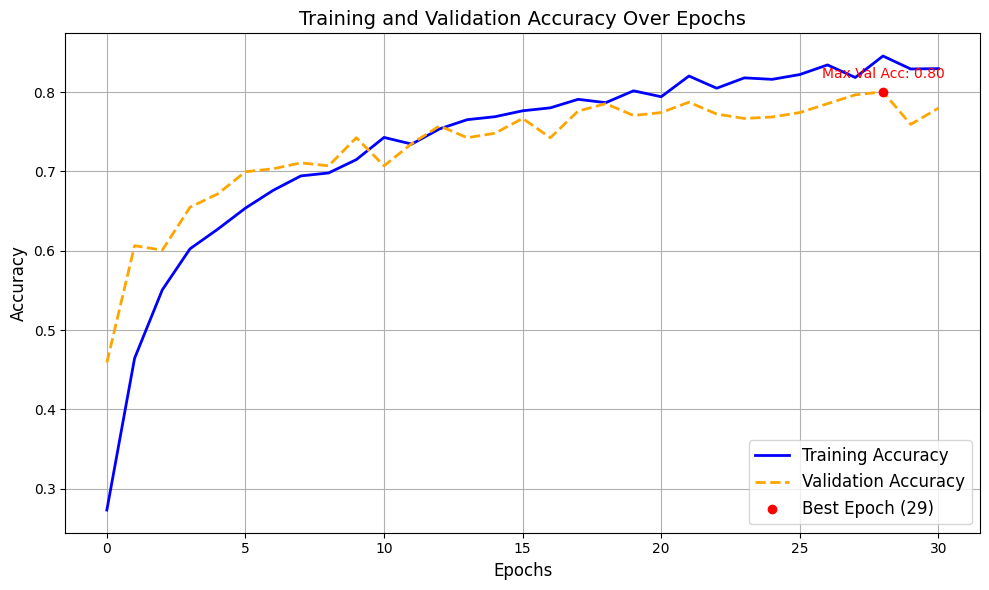

In [20]:
#'''
# Plotting of Training and Validation Accuracy

# Extract accuracy data from the training history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Determine the best epoch based on validation accuracy
best_epoch = np.argmax(val_acc)
best_val_acc = val_acc[best_epoch]

# Plot the training accuracy curve
plt.figure(figsize=(10, 6))  # Set the figure size for better visibility
plt.plot(train_acc, label='Training Accuracy', color='blue', linewidth=2, linestyle='-')  # Plot with thicker line
plt.plot(val_acc, label='Validation Accuracy', color='orange', linewidth=2, linestyle='--')  # Dashed line for validation

# Highlight the best validation accuracy point
plt.scatter(best_epoch, best_val_acc, color='red', label=f'Best Epoch ({best_epoch + 1})', zorder=5)
plt.annotate(f'Max Val Acc: {best_val_acc:.2f}',
             (best_epoch, best_val_acc),
             textcoords="offset points",
             xytext=(0, 10),
             ha='center',
             fontsize=10,
             color='red')

# Add labels, legend, and title
plt.xlabel('Epochs', fontsize=12)  # Label x-axis with larger font size
plt.ylabel('Accuracy', fontsize=12)  # Label y-axis with larger font size
plt.title('Training and Validation Accuracy Over Epochs', fontsize=14)  # Add a title with larger font
plt.grid(True)  # Add gridlines to improve readability
plt.legend(loc='lower right', fontsize=12)  # Position the legend and increase its font size

# Show the plot
plt.tight_layout()  # Adjust layout to make sure everything fits well
plt.show()
#'''

## Evaluating Model Performance on the Test Set

In this step, we evaluate the performance of the trained model on the test dataset by generating predictions and calculating metrics like precision, recall, and F1-score. These metrics provide insight into how well the model performs in distinguishing between the different classes.

### Key Metrics:
- **Precision**: Measures how many of the predicted positive samples are actually positive.
- **Recall**: Measures how many of the actual positive samples were correctly predicted.
- **F1-Score**: The harmonic mean of precision and recall, providing a balance between the two.

These metrics are calculated as **weighted averages** across all classes, providing an overall view of the model's performance.

In [21]:
# valuating Model Performance on the Test Set

# Generate predictions for the test dataset
test_pred = model.predict(X_test)  # Predict probabilities for each class
test_pred_class = test_pred.argmax(axis=1)  # Get the class with the highest probability for each prediction

# Extract true labels
y_test_class = Y_test  # Since Y_test is already in class label form

# Generate a classification report to evaluate model performance
report = metrics.classification_report(y_test_class, test_pred_class, output_dict=True)  # Output report as a dictionary

# Extracting mean precision, recall, and F1-score from the classification report
mean_precision = report['weighted avg']['precision']
mean_recall = report['weighted avg']['recall']
mean_f1_score = report['weighted avg']['f1-score']

# Output the mean values to summarize model performance
print(f'Mean Precision: {mean_precision:.2f}')
print(f'Mean Recall: {mean_recall:.2f}')
print(f'Mean F1-Score: {mean_f1_score:.2f}')


17/17 [==============================] - 3s 146ms/step
Mean Precision: 0.79
Mean Recall: 0.78
Mean F1-Score: 0.78


## Visualizing the Confusion Matrix with Seaborn

To better understand the classification results, we visualize the confusion matrix using Seaborn's heatmap. The confusion matrix shows how well the model performed for each class by displaying the counts of true vs. predicted labels.

Using Seaborn, we can:
- **Visualize Counts with Color Gradient**: The intensity of the color in each cell helps us quickly see where the model is performing well and where it may need improvement.
- **Display Annotations**: Each cell displays the exact count, making it easier to interpret the results.

The confusion matrix allows us to identify specific classes that the model finds challenging to distinguish.


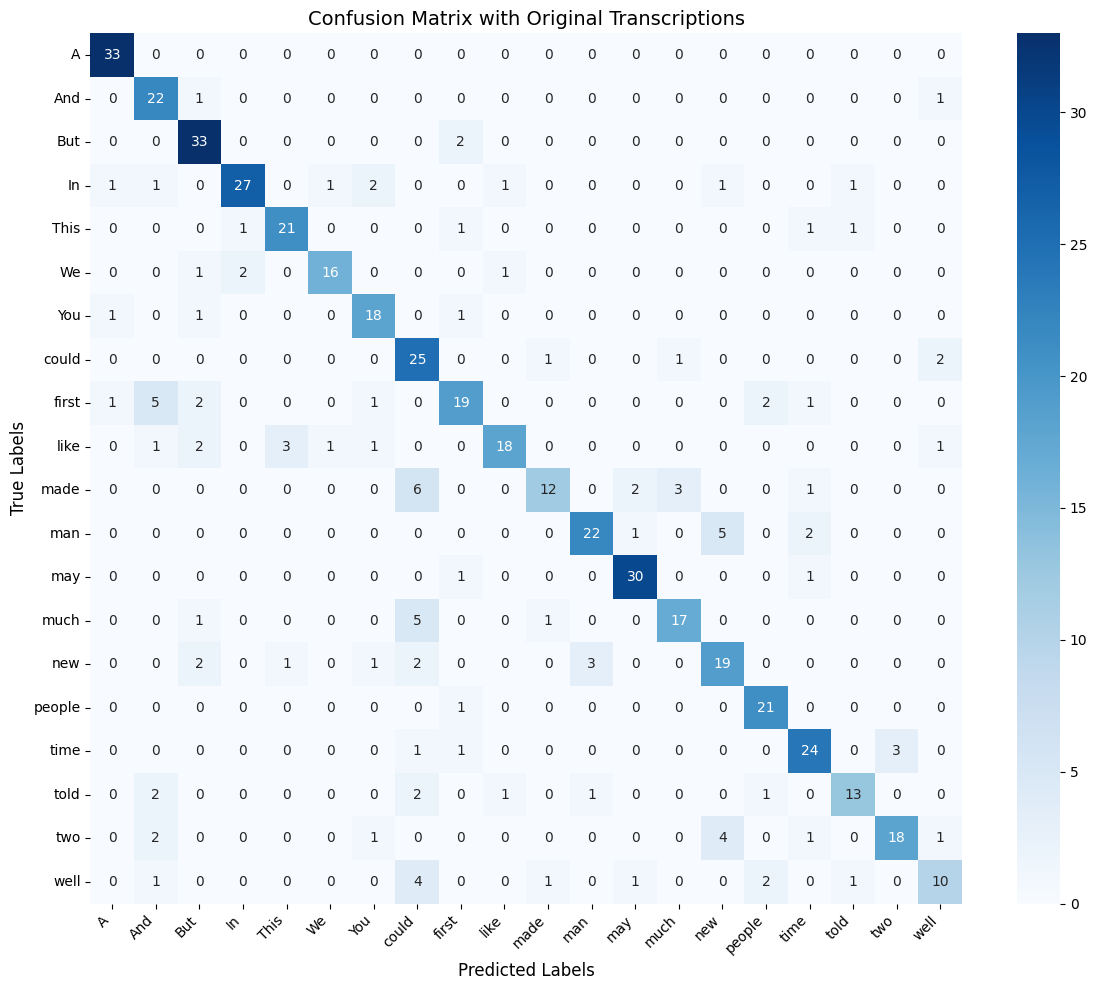

In [22]:
# Visualizing the Confusion Matrix with Original Transcriptions

# Generate the confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test_class, test_pred_class)

# Retrieve the original transcriptions for the labels using the LabelEncoder
original_labels = le.classes_

# Plot the confusion matrix using Seaborn heatmap with original transcription labels
plt.figure(figsize=(12, 10))  # Set the figure size for better readability
sns.heatmap(cnf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=original_labels, yticklabels=original_labels)  # Use original labels for better interpretability

# Add labels, title, and layout adjustments
plt.xlabel('Predicted Labels', fontsize=12)  # Label for x-axis
plt.ylabel('True Labels', fontsize=12)  # Label for y-axis
plt.title('Confusion Matrix with Original Transcriptions', fontsize=14)  # Add a title
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Ensure all elements are visible without overlap

# Show the plot
plt.show()


## Visualization of Misclassified Images

To gain insights into model performance, we visualize some of the misclassified images from the test dataset. This enhanced visualization allows us to:
- **Understand Model Errors**: Identify common errors and which transcriptions the model tends to misclassify.
- **Evaluate Confidence**: See how confident the model was when it made incorrect predictions.

### Visualization Elements:
1. **True vs. Predicted Transcription**: For each misclassified image, we display the true and predicted labels.
2. **Confidence Score**: The confidence level of the incorrect prediction is displayed, helping us understand if the model was overconfident about the wrong answer.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


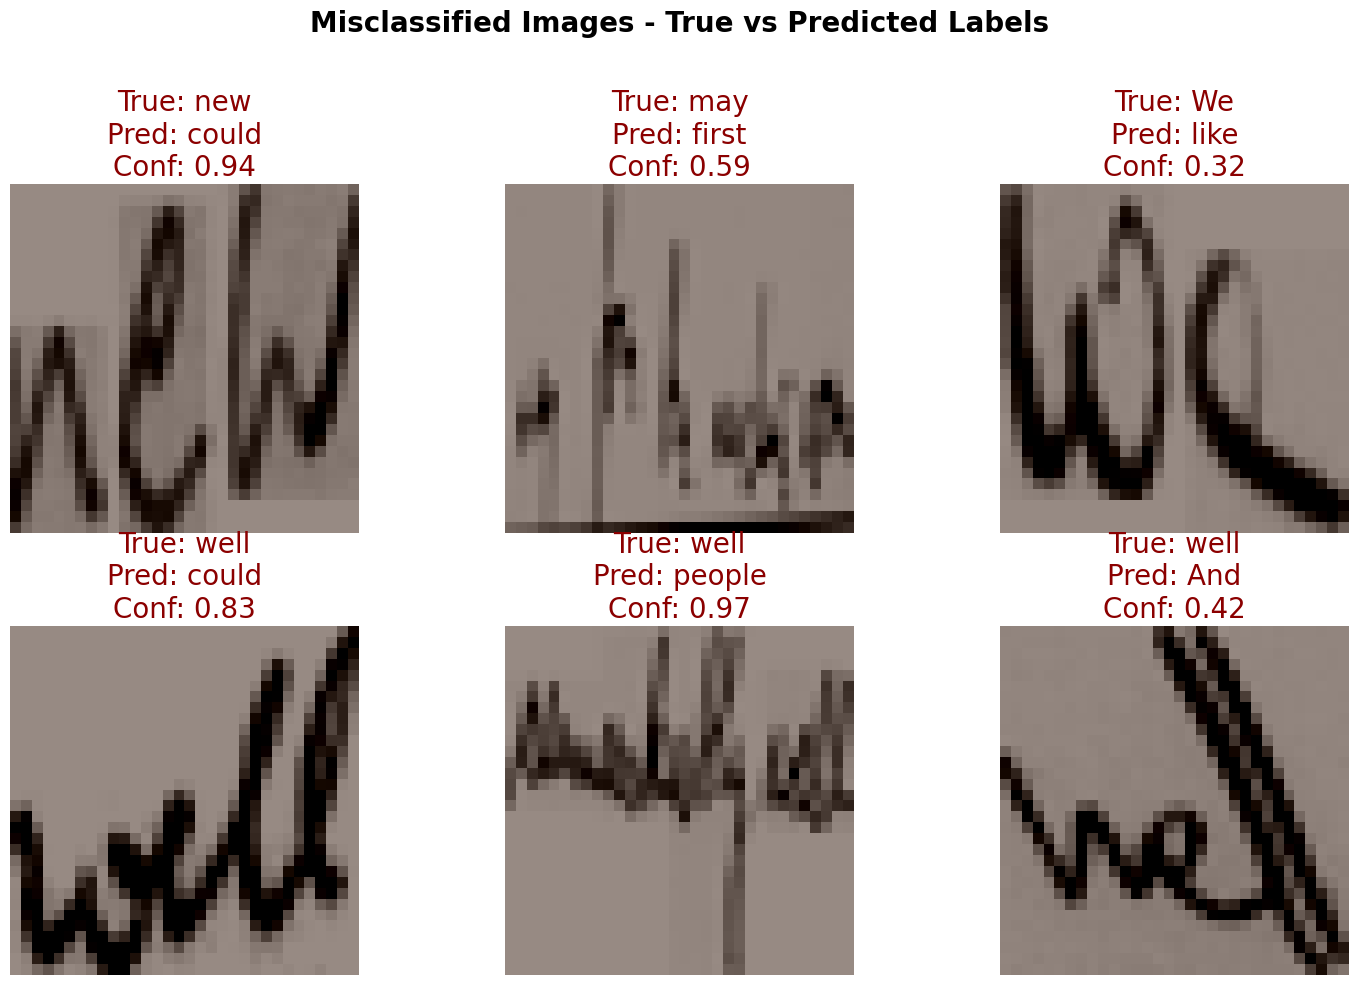

In [23]:
# Enhanced Visualization of Misclassified Images

# Create a mapping from class indices to original transcriptions
class_mapping = {index: transcription for index, transcription in enumerate(pd.Series(Y).unique())}

# Identify indexes where the model made incorrect predictions
error_indexes = [i for i in range(len(test_pred)) if test_pred_class[i] != y_test_class[i]]

# Check if there are any misclassifications
if len(error_indexes) > 0:
    # Determine the number of misclassified images to display (up to 6)
    num_images = min(6, len(error_indexes))
    
    # Set up the plot for displaying misclassified images in a grid layout
    plt.figure(figsize=(15, 10))  # Set figure size for better visibility
    grid_cols = 3  # Number of columns in the grid
    grid_rows = (num_images + grid_cols - 1) // grid_cols  # Number of rows in the grid

    for j, i in enumerate(np.random.choice(error_indexes, size=num_images, replace=False)):
        img = X_test[i]  # Extract the misclassified image

        # Create subplot to display the image in the grid layout
        plt.subplot(grid_rows, grid_cols, j + 1)
        plt.axis('off')  # Hide axes for better visualization
        plt.imshow(img, cmap=cm.binary)  # Display the image in grayscale

        # Get the true and predicted transcriptions for the misclassified image
        true_transcription = df_filtered.loc[df_filtered['transcription_encoded'] == Y_test[i], 'transcription'].iloc[0]
        predicted_transcription = df_filtered.loc[df_filtered['transcription_encoded'] == test_pred_class[i], 'transcription'].iloc[0]
        confidence = str(round(test_pred[i][test_pred_class[i]], 2))  # Get the confidence score for the predicted class

        # Add a title to each subplot with True label, Predicted label, and Confidence score
        plt.title(f'True: {true_transcription}\nPred: {predicted_transcription}\nConf: {confidence}',
                  fontsize=20, color='darkred')  # Use red color to highlight misclassification
    
    # Adjust layout to make sure everything is clearly visible
    plt.subplots_adjust(hspace=0.5, wspace=0.5)  # Add spacing between images to avoid overlap
    plt.suptitle('Misclassified Images - True vs Predicted Labels', fontsize=20, color='black', weight='bold')  # Add a title to the whole plot
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to avoid overlap with the super title
    plt.show()
else:
    print("No errors in predictions.")  # Print if no errors in predictions


## Predicting on Custom Handwritten Images

In this step, we use the trained model to predict handwritten images from a custom folder (`my_handwriting`). We loop through each image, preprocess it, and use the model to predict the transcription.

### Steps:
1. **Load Images from Folder**: Load each image from the specified folder containing custom handwritten images.
2. **Preprocess Images**: Resize and prepare each image for input to the model.
3. **Model Prediction**: Predict the transcription for each image and calculate the confidence of the prediction.
4. **Store Results**: Store the true label, predicted label, and confidence for each image in a DataFrame for easy visualization.

This helps evaluate how well the model performs on new, unseen handwritten images.


In [10]:
# Folder with handwritten images
folder_path = '../../my_handwriting'
results = []

# Loop through each image in the folder
for img_name in os.listdir(folder_path):
    img_path = os.path.join(folder_path, img_name)
    
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(32, 32))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    
    # Predict
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions)
    confidence = round(np.max(predictions) * 100, 2)  # Confidence as percentage
    
    # Get predicted and true labels
    predicted_label = le.inverse_transform([predicted_class])[0]
    true_label = img_name.split('.')[0]  # Assuming filename is the word
    
    # Append result to list
    results.append({
        'Image': img_name,
        'True Label': true_label,
        'Predicted Label': predicted_label,
        'Confidence (%)': confidence
    })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)



1/1 [==============================] - 0s 67ms/step
         Image True Label Predicted Label  Confidence (%)
0        A.jpg          A          people          100.00
1      And.jpg        And           first           69.44
2      But.jpg        But             And           99.68
3    could.jpg      could           first          100.00
4    first.jpg      first            told           96.97
5       In.jpg         In             And          100.00
6     like.jpg       like            time          100.00
7     made.jpg       made           first          100.00
8      man.jpg        man            told          100.00
9      may.jpg        may           first          100.00
10    much.jpg       much            time          100.00
11     new.jpg        new            time          100.00
12  people.jpg     people          people          100.00
13    This.jpg       This             But           99.96
14    time.jpg       time           first          100.00
15    told.jpg      

## Visualizing Prediction Confidence for Each Handwritten Image

To gain further insights into the model's predictions, we plot the confidence level for each handwritten image from the custom dataset. This visualization helps in:

1. **Understanding Model Confidence**: See how confident the model was in its predictions for each image.
2. **Identifying Correct vs. Incorrect Predictions**: Correct predictions are shown in green, while incorrect ones are shown in red, making it easy to visually distinguish the two.

This can help identify images that the model was unsure of and may benefit from further improvements or retraining.


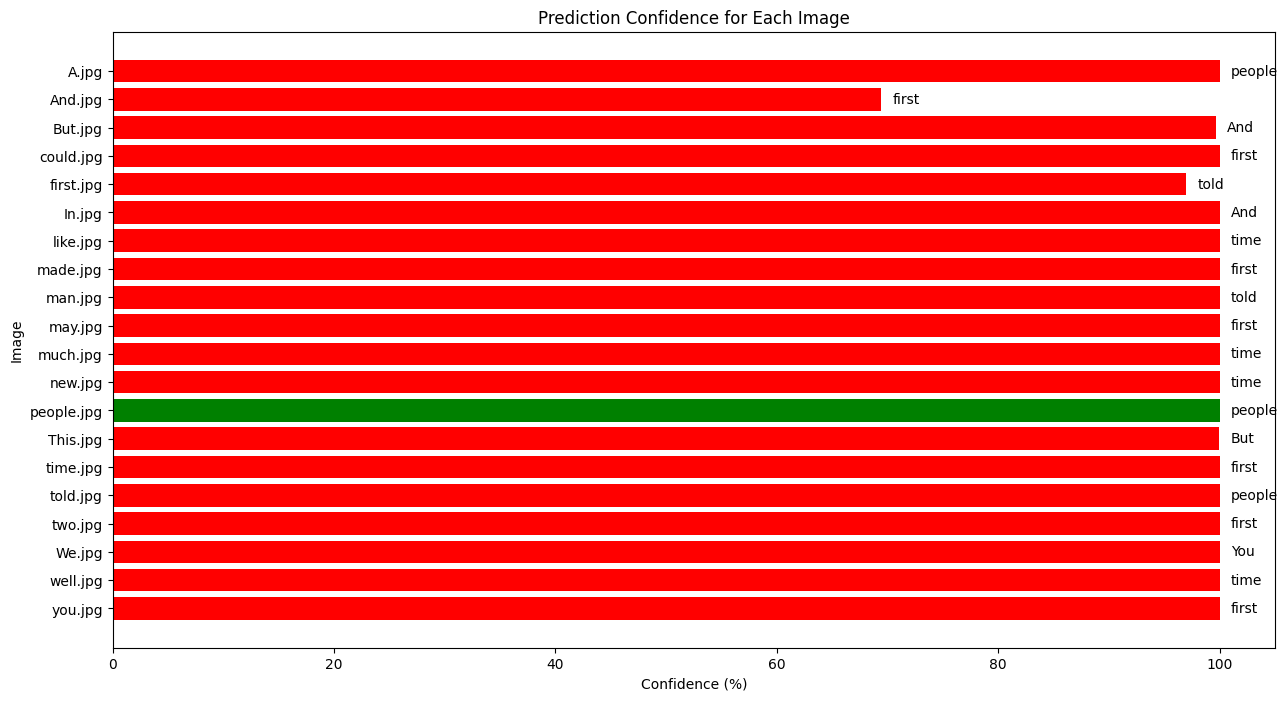

In [11]:
# Plot confidence for each prediction
plt.figure(figsize=(15, 8))
colors = ['green' if str(row['True Label']) == str(row['Predicted Label']) else 'red' for index, row in results_df.iterrows()]
plt.barh(results_df['Image'], results_df['Confidence (%)'], color=colors)
plt.xlabel("Confidence (%)")
plt.ylabel("Image")
plt.title("Prediction Confidence for Each Image")
plt.gca().invert_yaxis()  # Flip the y-axis for better readability

# Show predicted labels on the bars
for index, row in results_df.iterrows():
    plt.text(row['Confidence (%)'] + 1, index, f"{row['Predicted Label']}", color="black", va="center")

plt.show()

## Un-Freezing Layers for Fine-Tuning VGG16
To make the model more adaptable to our new dataset, we "un-freeze" the **last 4 layers** of the VGG16 model. This means that these layers will become trainable, allowing the model to learn features that are more specialized for our particular task. Fine-tuning the final layers while keeping the others frozen is a good way to leverage the generic features learned by VGG16 while adapting it to our data.


In [27]:
#"Un-freeze" the last 4 layers of the vgg16 model
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Add custom layers on top of VGG16
model2 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(n_class, activation='softmax')
])

model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


## Training the Updated Model


In [28]:
#'''
unfreez_history = model2.fit(
    train_dataset,
    epochs=50,
    verbose=1,
    class_weight=class_weights_dict_manual,
    validation_data=test_dataset,
    callbacks=[early_stopping, model_checkpoint]
)
#'''

Epoch 1/50
34/34 [==============================] - 25s 676ms/step - loss: 0.1144 - accuracy: 0.2888 - val_loss: 1.6619 - val_accuracy: 0.4478
Epoch 2/50
34/34 [==============================] - 23s 668ms/step - loss: 0.0655 - accuracy: 0.5268 - val_loss: 1.0248 - val_accuracy: 0.6791
Epoch 3/50
34/34 [==============================] - 23s 670ms/step - loss: 0.0500 - accuracy: 0.6468 - val_loss: 0.9126 - val_accuracy: 0.6978
Epoch 4/50
34/34 [==============================] - 23s 675ms/step - loss: 0.0397 - accuracy: 0.7228 - val_loss: 0.7766 - val_accuracy: 0.7724
Epoch 5/50
34/34 [==============================] - 24s 697ms/step - loss: 0.0330 - accuracy: 0.7704 - val_loss: 0.7100 - val_accuracy: 0.8284
Epoch 6/50
34/34 [==============================] - 23s 693ms/step - loss: 0.0301 - accuracy: 0.7961 - val_loss: 0.7955 - val_accuracy: 0.7612
Epoch 7/50
34/34 [==============================] - 23s 676ms/step - loss: 0.0258 - accuracy: 0.8283 - val_loss: 0.6485 - val_accuracy: 0.8078

## Saving and Reloading the Trained Updated Model

In [12]:
# Saving and Reloading the Trained Model

# Save the trained model to an H5 file
# This allows you to store the model's architecture, weights, and optimizer state in a single file

#model2.save("vgg16_28_28_unfreez_last_4.h5")
#print("Model saved successfully.")

# OPTIONAL: Uncomment the following line to load the trained model without retraining
# This is useful for resuming training or for making predictions without retraining from scratch

model2 = load_model("vgg16_28_28_unfreez_last_4.h5")
print("Model loaded successfully.")

Model loaded successfully.


## Plotting Training and Validation Accuracy

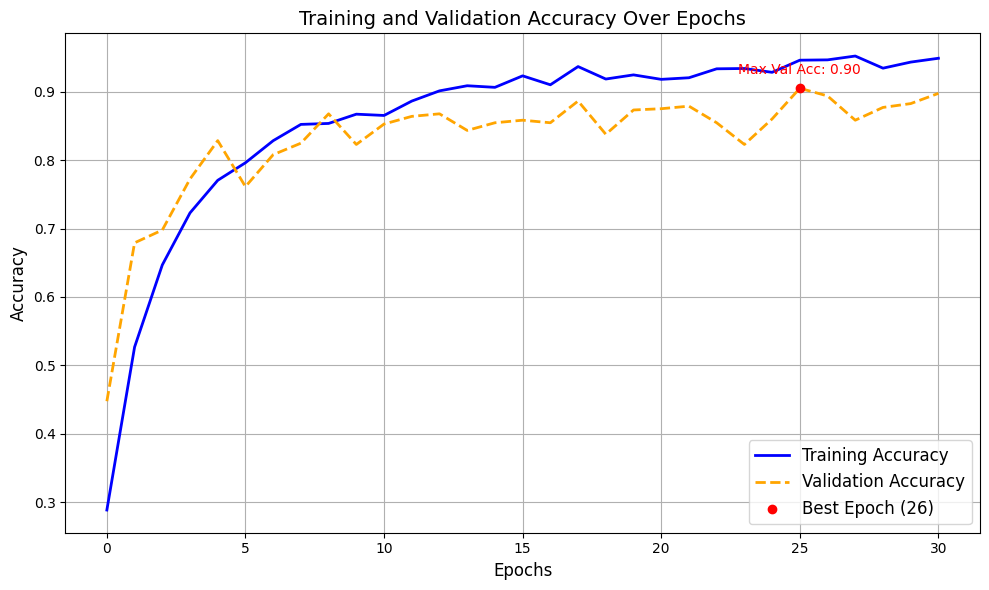

In [30]:
# Plotting of Training and Validation Accuracy

# Extract accuracy data from the training history
train_acc = unfreez_history.history['accuracy']
val_acc = unfreez_history.history['val_accuracy']

# Determine the best epoch based on validation accuracy
best_epoch = np.argmax(val_acc)
best_val_acc = val_acc[best_epoch]

# Plot the training accuracy curve
plt.figure(figsize=(10, 6))  # Set the figure size for better visibility
plt.plot(train_acc, label='Training Accuracy', color='blue', linewidth=2, linestyle='-')  # Plot with thicker line
plt.plot(val_acc, label='Validation Accuracy', color='orange', linewidth=2, linestyle='--')  # Dashed line for validation

# Highlight the best validation accuracy point
plt.scatter(best_epoch, best_val_acc, color='red', label=f'Best Epoch ({best_epoch + 1})', zorder=5)
plt.annotate(f'Max Val Acc: {best_val_acc:.2f}',
             (best_epoch, best_val_acc),
             textcoords="offset points",
             xytext=(0, 10),
             ha='center',
             fontsize=10,
             color='red')

# Add labels, legend, and title
plt.xlabel('Epochs', fontsize=12)  # Label x-axis with larger font size
plt.ylabel('Accuracy', fontsize=12)  # Label y-axis with larger font size
plt.title('Training and Validation Accuracy Over Epochs', fontsize=14)  # Add a title with larger font
plt.grid(True)  # Add gridlines to improve readability
plt.legend(loc='lower right', fontsize=12)  # Position the legend and increase its font size

# Show the plot
plt.tight_layout()  # Adjust layout to make sure everything fits well
plt.show()

## Evaluating Model Performance on the Test Set

In [31]:
# valuating Model Performance on the Test Set

# Generate predictions for the test dataset
test_pred = model2.predict(X_test)  # Predict probabilities for each class
test_pred_class = test_pred.argmax(axis=1)  # Get the class with the highest probability for each prediction

# Extract true labels
y_test_class = Y_test  # Since Y_test is already in class label form

# Generate a classification report to evaluate model performance
report = metrics.classification_report(y_test_class, test_pred_class, output_dict=True)  # Output report as a dictionary

# Extracting mean precision, recall, and F1-score from the classification report
mean_precision = report['weighted avg']['precision']
mean_recall = report['weighted avg']['recall']
mean_f1_score = report['weighted avg']['f1-score']

# Output the mean values to summarize model performance
print(f'Mean Precision: {mean_precision:.2f}')
print(f'Mean Recall: {mean_recall:.2f}')
print(f'Mean F1-Score: {mean_f1_score:.2f}')

17/17 [==============================] - 3s 151ms/step
Mean Precision: 0.90
Mean Recall: 0.90
Mean F1-Score: 0.90


## Visualizing the Confusion Matrix with Seaborn

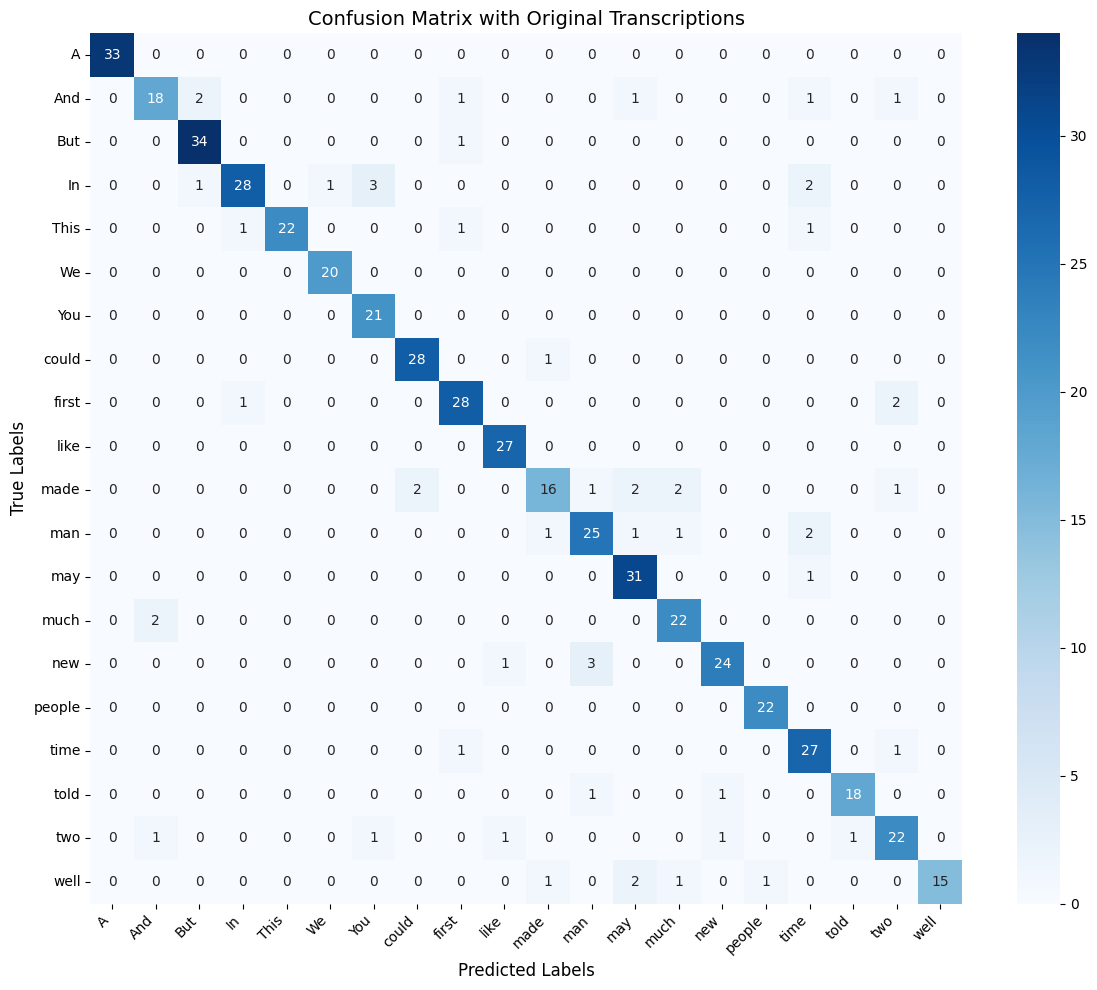

In [32]:
# Visualizing the Confusion Matrix with Original Transcriptions

# Generate the confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test_class, test_pred_class)

# Retrieve the original transcriptions for the labels using the LabelEncoder
original_labels = le.classes_

# Plot the confusion matrix using Seaborn heatmap with original transcription labels
plt.figure(figsize=(12, 10))  # Set the figure size for better readability
sns.heatmap(cnf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=original_labels, yticklabels=original_labels)  # Use original labels for better interpretability

# Add labels, title, and layout adjustments
plt.xlabel('Predicted Labels', fontsize=12)  # Label for x-axis
plt.ylabel('True Labels', fontsize=12)  # Label for y-axis
plt.title('Confusion Matrix with Original Transcriptions', fontsize=14)  # Add a title
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Ensure all elements are visible without overlap

# Show the plot
plt.show()

## Predicting on Custom Handwritten Images

In [13]:
# Folder with handwritten images
folder_path = '../../my_handwriting'
results = []

# Loop through each image in the folder
for img_name in os.listdir(folder_path):
    img_path = os.path.join(folder_path, img_name)
    
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(32, 32))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    
    # Predict
    predictions = model2.predict(img_array)
    predicted_class = np.argmax(predictions)
    confidence = round(np.max(predictions) * 100, 2)  # Confidence as percentage
    
    # Get predicted and true labels
    predicted_label = le.inverse_transform([predicted_class])[0]
    true_label = img_name.split('.')[0]  # Assuming filename is the word
    
    # Append result to list
    results.append({
        'Image': img_name,
        'True Label': true_label,
        'Predicted Label': predicted_label,
        'Confidence (%)': confidence
    })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)



1/1 [==============================] - 0s 77ms/step
         Image True Label Predicted Label  Confidence (%)
0        A.jpg          A          people          100.00
1      And.jpg        And             And          100.00
2      But.jpg        But           first          100.00
3    could.jpg      could           first          100.00
4    first.jpg      first             But          100.00
5       In.jpg         In              In           99.96
6     like.jpg       like          people          100.00
7     made.jpg       made           first          100.00
8      man.jpg        man          people          100.00
9      may.jpg        may             may          100.00
10    much.jpg       much          people          100.00
11     new.jpg        new          people          100.00
12  people.jpg     people          people          100.00
13    This.jpg       This            This          100.00
14    time.jpg       time          people          100.00
15    told.jpg      

## Visualizing Prediction Confidence for Each Handwritten Image

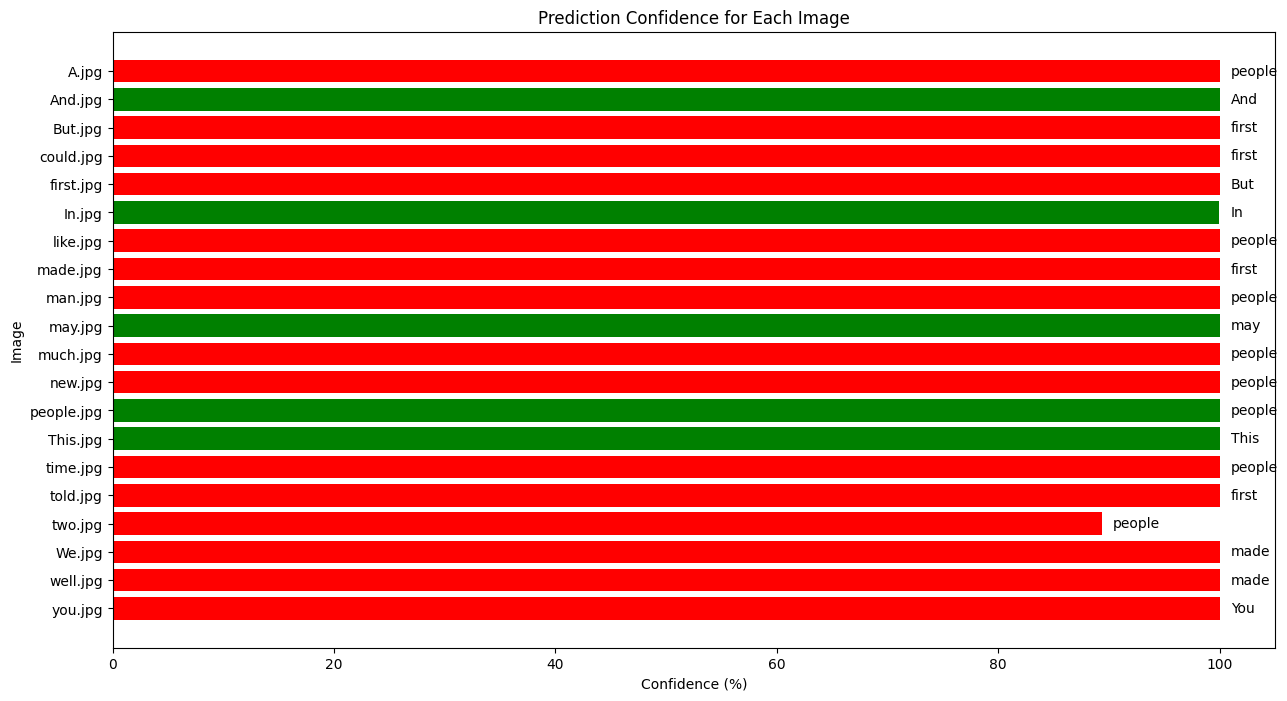

In [14]:
# Plot confidence for each prediction
plt.figure(figsize=(15, 8))
colors = ['green' if str(row['True Label']) == str(row['Predicted Label']) else 'red' for index, row in results_df.iterrows()]
plt.barh(results_df['Image'], results_df['Confidence (%)'], color=colors)
plt.xlabel("Confidence (%)")
plt.ylabel("Image")
plt.title("Prediction Confidence for Each Image")
plt.gca().invert_yaxis()  # Flip the y-axis for better readability

# Show predicted labels on the bars
for index, row in results_df.iterrows():
    plt.text(row['Confidence (%)'] + 1, index, f"{row['Predicted Label']}", color="black", va="center")

plt.show()